# Processing Daily Climate Anomalies
General Workflow is to Load:
 1. Netcdf files containing observed SST from 1982-Present
 2. Netcdf containing 30-year Climatology Means for each day of the year
 
Then pair each observed daily mean with the appropriate 30-year climatology and calculate the difference

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

#Suppress divide by NA error
np.seterr(divide='ignore', invalid='ignore')

#ensure we're in correct directory
os.chdir("/Users/akemberling/Documents/oisst_mainstays")

## Open Daily Climatologies 

In [2]:
#daily_clims = xr.open_dataset('daily_climatologies/daily_clims_82to2011.nc')
daily_clims = xr.open_mfdataset('daily_climatologies/daily_clims_82to2011.nc',
                               combine = "by_coords")
daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>

### Plot a Day -  Test

In [3]:
def plot_yearday_sst(day_year = 1):
    
    daily_sst = daily_clims['sst'].sel(modified_ordinal_day = day_year)
    
    fig = plt.figure(figsize=[12,5])

    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    fig.suptitle('30-Year SST Climatology for the ' + str(day_year) + 'th day of the year.', fontsize=16)

    daily_sst.plot.contourf(ax=ax,
                       levels=np.arange(0, 30, 1.5),
                       extend='max',
                       transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': daily_sst.units})
    ax.coastlines()

    plt.show()

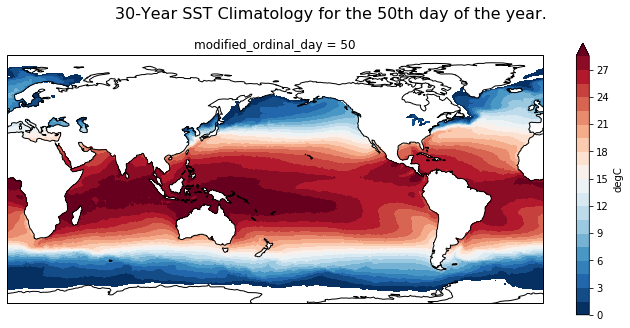

In [4]:
plot_yearday_sst(day_year = 50)

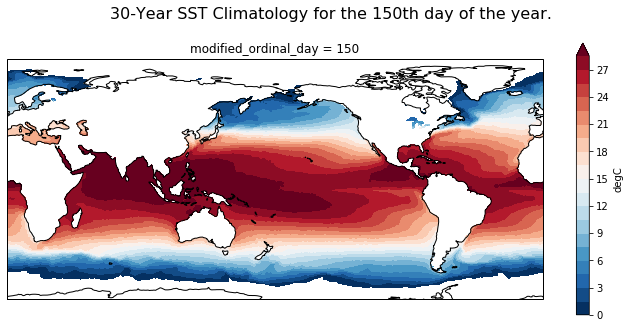

In [5]:
plot_yearday_sst(day_year = 150)

## Bring in Daily SST Data
Lazy-load the annual netcdf files for the oisst sst data.

In [7]:
#ensure we're in correct directory
os.chdir("/Users/akemberling/Documents/oisst_mainstays/annual_observations")

#Load/append all the annual netcdf files
sst_obs = xr.open_mfdataset('*.nc', parallel=True, combine='by_coords')
sst_obs

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Make modified ordinal day index
Need an index of what day of the year it is (that isn't sensitive to leap-years) to match the observed sst values with the 30-year climatologies

In [8]:
not_leap_year = ~sst_obs.indexes['time'].is_leap_year

march_or_later = sst_obs.time.dt.month >= 3

ordinal_day = sst_obs.time.dt.dayofyear

modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

Now add that dimension to the big observed sst array

In [9]:
modified_ordinal_day

<xarray.DataArray 'modified_ordinal_day' (time: 13636)>
array([245, 246, 247, ..., 364, 365, 366])
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31

In [10]:
#Add modified ordinal day as a variable
sst_obs = sst_obs.assign(modified_ordinal_day = modified_ordinal_day)
sst_obs

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
    modified_ordinal_day  (time) int64 245 246 247 248 249 ... 363 364 365 366
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [11]:
#compare to daily climatologies structure
daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>

In [12]:
#Indexing by coordinates
sst_obs[dict(lat=0, lon=0, time=0)]['sst']

<xarray.DataArray 'sst' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lon      float32 0.125
    lat      float32 -89.875
    time     datetime64[ns] 1981-09-01
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

In [13]:
#Indexing by values to pull the ordinal day
sst_obs.sel(time='1982-03-01')['modified_ordinal_day']

<xarray.DataArray 'modified_ordinal_day' ()>
array(61)
Coordinates:
    time     datetime64[ns] 1982-03-01

In [14]:
#Maybe need to add modified ordinal day as coord
sst_obs = sst_obs.assign_coords(MOD = modified_ordinal_day)

#Do they align with the time coord?
sst_obs.sel(time='2000-03-01')

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    modified_ordinal_day  int64 61
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

### Matching them up for arithmetic
So now the observed dataset contains the modified ordinal day of the year which we can use to match with the corresponding daily climatology

In [15]:
test_day_obs = sst_obs.sel(time='2000-03-01')
test_day_obs

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    modified_ordinal_day  int64 61
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [16]:
test_day_clim = daily_clims.sel(modified_ordinal_day = test_day_obs["MOD"])
test_day_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
    modified_ordinal_day  int64 61
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>

In [17]:
test_day_anom = test_day_obs - test_day_clim
test_day_anom = test_day_anom['sst'].rename('sst_anom')

### Test Day Anomaly - Plot

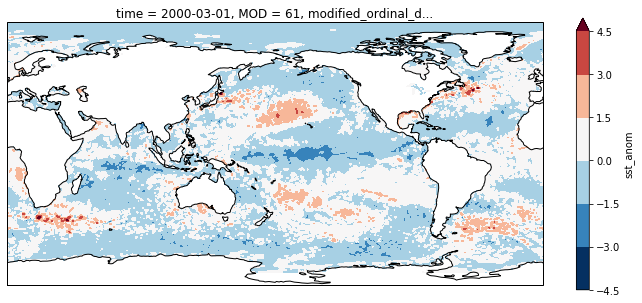

In [18]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

test_day_anom.plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

In [88]:
np.arange(-4.5, 4.5, 1.5)

array([-4.5, -3. , -1.5,  0. ,  1.5,  3. ])

## GroupBy "time": split-apply-combine
So from the full daily set, we want to group by the time to split out each day. Then use the modified ordinal day to subtract the matching climatology. I don't think we'll need to worry about the leap-years but we'll see...

In [19]:
sst_obs.groupby('time')

DatasetGroupBy, grouped over 'time' 
13636 groups with labels 1981-09-01, ..., 2018-12-31.

Define the function that will take a daily slice of the observed sst, and subtract it by its matching climatology:

In [20]:
def calc_anom(daily_sst):
    return daily_sst - daily_clims.sel(modified_ordinal_day = daily_sst["MOD"])

### Moment of Truth
Can we apply it top every day?

In [21]:
daily_anoms = sst_obs.groupby('time').map(calc_anom)

### Plot Test...

In [22]:
daily_anoms

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
    MOD                   (time) int64 245 246 247 248 249 ... 363 364 365 366
    modified_ordinal_day  (time) int64 245 246 247 248 249 ... 363 364 365 366
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

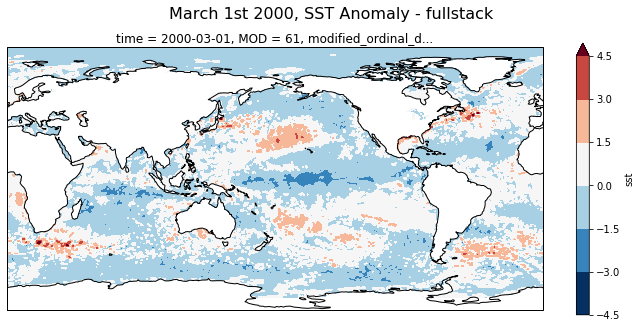

In [23]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
fig.suptitle('March 1st 2000, SST Anomaly - fullstack', fontsize=16)

daily_anoms.sel(time = '2000-03-01')['sst'].plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

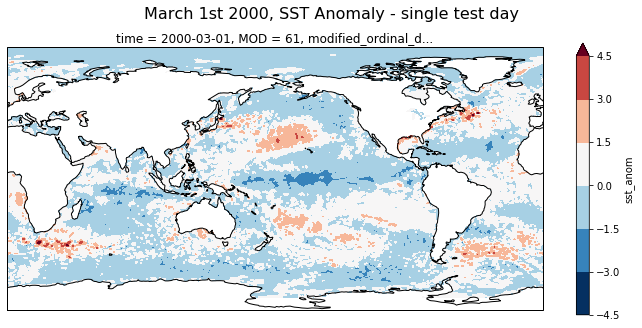

In [24]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
fig.suptitle('March 1st 2000, SST Anomaly - single test day', fontsize=16)

test_day_anom.plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

In [25]:
daily_anoms

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
    MOD                   (time) int64 245 246 247 248 249 ... 363 364 365 366
    modified_ordinal_day  (time) int64 245 246 247 248 249 ... 363 364 365 366
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [26]:
#Export as annual netcdf files
for year, group in daily_anoms.groupby('time.year'):
    group.to_netcdf(f'/Users/akemberling/Documents/oisst_mainstays/annual_anomalies/daily_anoms_{year}.nc')
    